# Solving the Schr&ouml;dinger equation in a 1D well

As an example of an eigenvalue We will solve the 1D Schr&ouml;dinger equation:
$$-\frac{\hbar}{2m}\frac{d^2\psi}{dx^2}+V(x)\psi(x)=E\psi(x)$$
in an infinite square well:
$$V(x)=\begin{cases}
    0,& \text{for } 0 < x < L\\
    \infty,              & \text{elsewhere}
\end{cases}$$

We perform the usual trick
$$\frac{d\psi}{dx}=\phi, \; \; \; \frac{d\phi}{dx}=\frac{2m}{\hbar^2}[V(x)-E]\psi.$$
Our initial condition is $\psi(0)=0$, and our boundary contdition is $\psi(L)=0$. We do not know that $\phi$ should be.


We will first choose an arbitrary energy $E$ and plot $\psi(x)$.

In [10]:
import numpy as np
import scipy.constants as c
import matplotlib.pyplot as plt

class schrodingerOneDwell:
    '''Class for solving our boundary value problem of 1D schrodinger equation.'''

    def __init__(self,E=700*c.e,Vx=None,x0=0,L=(c.hbar/(c.m_e*c.c*c.alpha)),\
                 psi0=0.0,psiL=0.0,phi0=1.0,nRKsteps=1000):
        self.Vx=Vx
        self.E=E
        self.rkPoints = np.linspace(x0,L,nRKsteps)
        self.deltaX=(L-x0)/nRKsteps
        self.psi0=psi0
        
        self.psiOfx=self.rk4(phi0)   

    def f(self,r,x,E):
        '''RHS of RK'''
        psi=r[0]
        phi=r[1]
        fpsi=phi
        fphi=(2*c.m_e/c.hbar**2)*(self.Vx(x)-E)*psi
        return np.array([fpsi,fphi])
    
    
    def rk4(self,phi):
        '''Evaluating the height for a given velocity using the RK method'''
        r=np.array([self.psi0,phi])
        dx=self.deltaX
        E=self.E
        
        psiOfx=np.array([])
        for x in self.rkPoints:
            k1=dx*self.f(r,x,E)
            k2=dx*self.f(r+0.5*k1,x+0.5*dx,E)
            k3=dx*self.f(r+0.5*k2,x+0.5*dx,E)
            k4=dx*self.f(r+k3,x+dx,E)
            r+=(k1+2.0*k2+2.0*k3+k4)/6.0
            
            psiOfx=np.append(psiOfx,r[0])
            
        return psiOfx

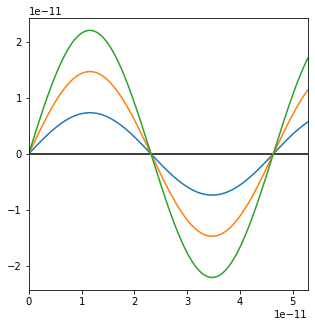

In [24]:
def V(x):
    '''Somewhat trivial potential'''
    return 0.0

phiOne=schrodingerOneDwell(Vx=V)
phiTwo=schrodingerOneDwell(Vx=V,phi0=2.0)
phiThree=schrodingerOneDwell(Vx=V,phi0=3.0)

fig1,ax1=plt.subplots(figsize=(5,5))

ax1.plot(phiOne.rkPoints,np.zeros(len(phiOne.rkPoints)),'k')

ax1.plot(phiOne.rkPoints,phiOne.psiOfx)
ax1.plot(phiTwo.rkPoints,phiTwo.psiOfx)
ax1.plot(phiThree.rkPoints,phiThree.psiOfx)

ax1.set_xlim(phiOne.rkPoints[0],phiOne.rkPoints[-1])

plt.savefig('oneDwell_ex.pdf',bbox_inches='tight')

plt.show()

Notice that changing the initial condition $\phi$ just scales the function (because the ODE is linear). Thus we will never be able to choose $\phi$ so that the boundary condition $\psi(L)=0$ is satisfied.

But we already know why this is the case. The Schr&ouml;dinger equation only has valid solutions for specific $E$. So our task is really to find $E$ such that $\psi(L)=0$. $\phi$ can be set by enforcing some normalization of the wavefunction.

In [12]:
class schrodingerSolveE:
    '''Class for solving our boundary value problem of 1D schrodinger equation, solving for E'''

    def __init__(self,E_guess=[c.e,200*c.e],Vx=None,x0=0.0,L=(c.hbar/(c.m_e*c.c*c.alpha)),\
                 psi0=0.0,phi0=1.0,nRKsteps=1000,accuracy=c.e/1000):
        
        self.Vx=Vx
        self.L=L
        self.E_guess=E_guess
        self.rkPoints = np.linspace(x0,L,nRKsteps)
        self.deltaX=(L-x0)/nRKsteps
        self.psi0=psi0
        self.phi0=phi0
        
        self.E=self.secant_root(self.rk4,E_guess[0],E_guess[1],accuracy)
        

    def secant_root(self,func,E0,E1,accuracy):
        '''Calculate the root with the Secant method'''
        maxSteps=1000 # Limit the number of steps in case of divergence

        phi=self.phi0
        
        for step in range(maxSteps):

            derivative=((func(phi,E1)-func(phi,E0))/(E1-E0))
            if abs(derivative) < 1.0e-30:
                print('Derivative is too small: ',derivative, ', try different initial guesses.')
                raise
            else:
                E2=E1-func(phi,E1)/derivative
        
            if abs(E2) < 1.0e-30 and  abs(E2-E1) < accuracy:
                return E2


            elif abs(E2-E1) < abs(E2*accuracy):
                return E2

            E0=E1
            E1=E2

        # If we end up here, out root did not converge
        print('Root did not converge')
        raise
     
        
    def f(self,r,x,E):
        '''RHS of RK'''
        psi=r[0]
        phi=r[1]
        fpsi=phi
        fphi=(2*c.m_e/c.hbar**2)*(self.Vx(x,self.L)-E)*psi
        return np.array([fpsi,fphi])
    
    
    def rk4(self,phi,E):
        '''Evaluating the height for a given velocity using the RK method'''
        r=np.array([self.psi0,phi])
        dx=self.deltaX
        
        for x in self.rkPoints:
            k1=dx*self.f(r,x,E)
            k2=dx*self.f(r+0.5*k1,x+0.5*dx,E)
            k3=dx*self.f(r+0.5*k2,x+0.5*dx,E)
            k4=dx*self.f(r+k3,x+dx,E)
            r+=(k1+2.0*k2+2.0*k3+k4)/6.0
            
        return r[0]

In [18]:
def V(x,L):
    '''Somewhat trivial potential'''
    return 0.0

wellOne=schrodingerSolveE(Vx=V)
print(wellOne.E/c.e)

134.28280764025766


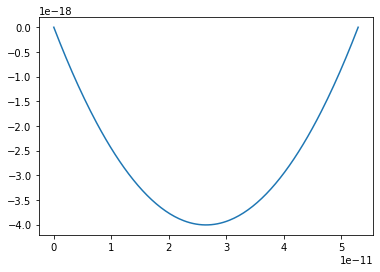

112.54305719495834


In [23]:
def V2(x,L):
    '''More complex potential'''
    return 100*c.e*(x/L)*(x/L-1)

# Plot to see what it looks like:
L=(c.hbar/(c.m_e*c.c*c.alpha))
x=np.linspace(0,L,200)
V=V2(x,L)
fig1,ax1=plt.subplots()

ax1.plot(x,V)
plt.show()

wellTwo=schrodingerSolveE(Vx=V2)
print(wellTwo.E/c.e)